# Are the average album scores of 2000-2009 different from those of 2010-2017?¶
$H_o$: Average song scores are the same in both periods.

$H_a$: Average song scores have changed in the more recent period.

$\alpha$: 0.05

In [1]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ztest

In [2]:
engine = create_engine('postgres:///music')
conn = engine.connect()
engine.table_names()

['reviews', 'artists', 'genres', 'labels', 'years', 'content']

# Data Extraction

### This time there are only three essential pieces of information we need from each review: album score, album release year, and the review ID to associate them with. 

In [3]:
query = """
SELECT
    reviews.reviewid,
    reviews.score,
    years.year
FROM reviews
FULL OUTER JOIN years ON years.reviewid = reviews.reviewid
ORDER BY years.year
"""
result = conn.execute(query)
df = pd.DataFrame(result.fetchall(), columns=result.keys())
df.head()

,reviewid,score,year
0,13258,8.2,1959.0
1,21797,9.0,1960.0
2,17864,8.3,1960.0
3,1544,9.4,1960.0
4,21098,8.6,1962.0


### Splitting the data into two sets: every album released in 2000-2009 and every album released in 2010-2017.

In [4]:
df = df[df['year'] >= 2000]

In [5]:
#2000-2009 to 2010-2017
range_1 = df[df['year'] >= 2010] #2010-2017
range_2 = df[df['year'] <= 2009] #2000-2009

In [6]:
range_1['year'].unique(), range_2['year'].unique()

(array([2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017.]),
 array([2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008.,
        2009.]))

# Data Investigation

### The mean values of these ranges are only slightly different, although our massive sample sizes might still allow us to definitively see a distinction in their distributions.

In [7]:
range_1['score'].mean(), range_2['score'].mean()

(7.065059501901666, 6.9611404757064586)

### Change in score over time is visually tiny, even on this 2x-zoomed scale.

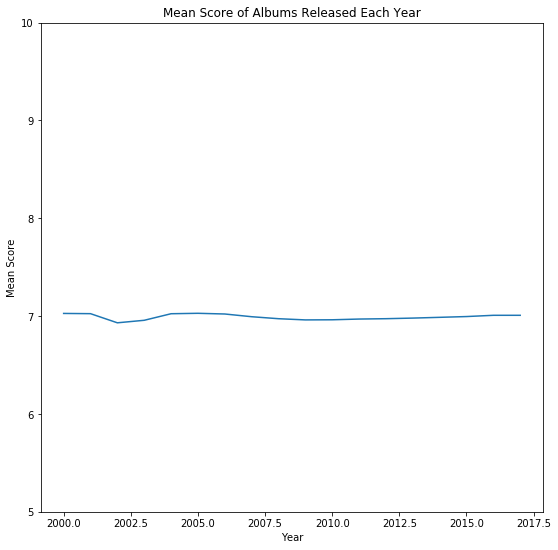

In [19]:
# Data was previously sorted by album release year during our SQL query
year_scores = []
years = list(range(2000, 2018))
for year in years:
    year_data = df[df['year'] <= year]
    year_scores.append(year_data['score'].mean())
    
plt.figure(figsize=(9,9))
plt.title('Mean Score of Albums Released Each Year')
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(5, 10)
sns.lineplot(years, year_scores);

### The raw numbers make these changes slightly more apparent, but also reconfirms the obvious: these differences are small.

In [9]:
year_scores

[7.027272727272724,
 7.024906132665827,
 6.931501416430574,
 6.957209302325574,
 7.024264514449359,
 7.028633577219705,
 7.021530334560591,
 6.99375665601706,
 6.973391644608156,
 6.9611404757064586,
 6.9623758768333905,
 6.969868779400846,
 6.973533393501808,
 6.979690949227359,
 6.987434420985272,
 6.995388190430773,
 7.008188792528326,
 7.008227249986077]

### There are slightly more noticeable differences between the two broader distributions we're comparing.

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


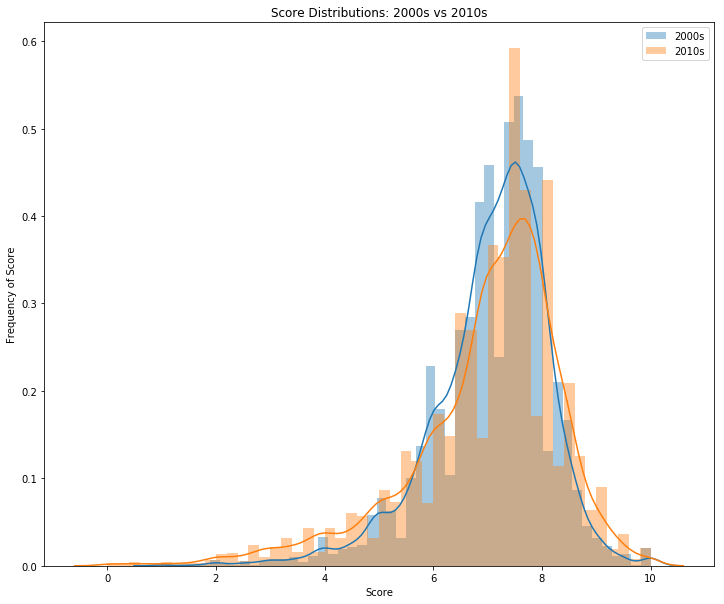

In [10]:
plt.figure(figsize=(12, 10))
plt.title('Score Distributions: 2000s vs 2010s')
sns.distplot(range_1['score'], label='2000s')
sns.distplot(range_2['score'], label='2010s')
plt.xlabel('Score')
plt.ylabel('Frequency of Score')
plt.legend();

### Rate of change in score year-over-year.

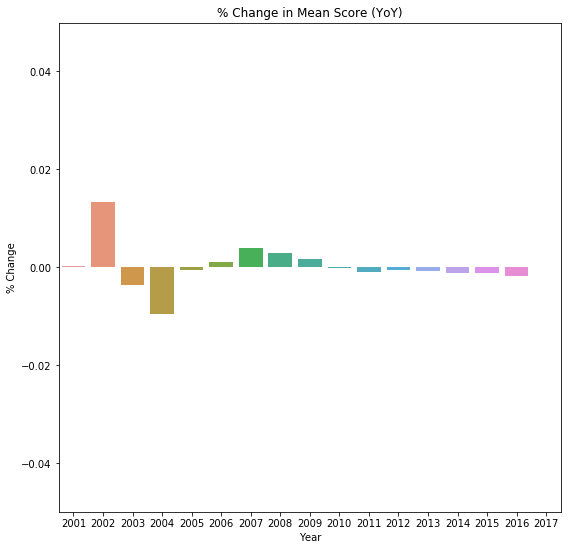

In [11]:
yoy_changes = []
for i in range(len(year_scores) - 1):
    yoy_change = 1 - (year_scores[i+1] / year_scores[i])
    yoy_changes.append(yoy_change)
    
plt.figure(figsize=(9,9))
plt.title('% Change in Mean Score (YoY)')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.ylim(-0.05, 0.05)
sns.barplot(years[1:], yoy_changes);

### Checking sample sizes, means, and standard deviations.

In [12]:
len(range_1), len(range_2)

(8151, 9838)

In [13]:
range_1['score'].mean(), range_2['score'].mean()

(7.065059501901666, 6.9611404757064586)

In [14]:
range_1['score'].std(), range_2['score'].std()

(1.077328492386676, 1.4230652729780706)

# What is the p-value for our two different sets?

In [15]:
z, p_value = ztest(range_1['score'], range_2['score'])
f'Z-statistic is {z} and p-value is {p_value}.'

'Z-statistic is 5.4287780851588 and p-value is 5.67411827977542e-08.'

### Suspiciously small--how could we be so confident that two things so similar *are* in fact different? 

### It may only be due to our large sample sizes. Lets test this theory by running z-tests on smaller samples of our data.

In [21]:
np.random.seed(25565)

In [22]:
sample_1 = np.random.choice(range_1['score'], 1000)
sample_2 = np.random.choice(range_2['score'], 1000)

z, p_value = ztest(sample_1, sample_2)
f'Z-statistic is {z} and p-value is {p_value}.'

'Z-statistic is 2.933448434400435 and p-value is 0.0033521933301589963.'

In [23]:
sample_1 = np.random.choice(range_1['score'], 100)
sample_2 = np.random.choice(range_2['score'], 100)

z, p_value = ztest(sample_1, sample_2)
f'Z-statistic is {z} and p-value is {p_value}.'

'Z-statistic is 1.5269829209030545 and p-value is 0.12676525836995117.'

In [24]:
sample_1 = np.random.choice(range_1['score'], 10)
sample_2 = np.random.choice(range_2['score'], 10)

z, p_value = ztest(sample_1, sample_2)
f'Z-statistic is {z} and p-value is {p_value}.'

'Z-statistic is 0.5654802992331465 and p-value is 0.5717471205566864.'

### The sample size seems to be making all the difference in the world here. Although the change in scores over time is extremely subtle, we can say with confidence that it is statistically significant.

# Conclusion

### Our p-value is well below our alpha of 0.05, so we can confidently *reject* our null hypothesis. The difference in mean score between the two time periods is small, but statistically significant.